# Exploration 14. 시계열 예측

## 시계열 데이터 사례분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8

In [3]:
#  Date를 index_col로 지정
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

In [4]:
ts1 = df['Temp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

## 시계열 안정석 (Stationarity) 의 정성적 분석

### 시각화


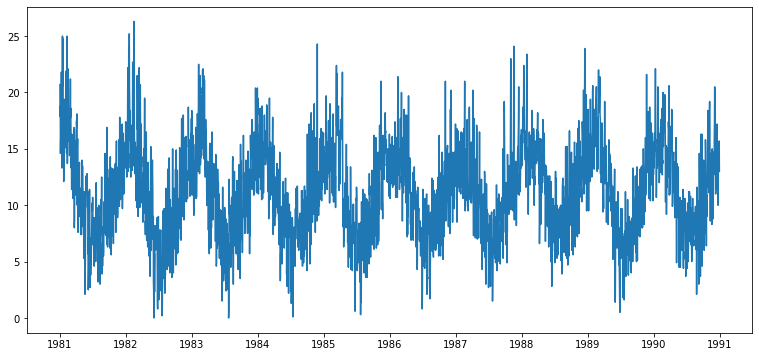

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

### 결측치 파악

In [6]:
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Temp, dtype: float64)

이 데이터에는 결측치가 없다.  

만약 결측치가 존재한다면, 두 가지 방법으로 결측치를 처리해 줄 수 있다.  
- 결측치가 있는 데이터를 모두 삭제 (drop)
- 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입
  - ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식
  - `interpolate` 메소드를 사용하여 결측치를 채울 수 있다.

Series([], Name: Temp, dtype: float64)


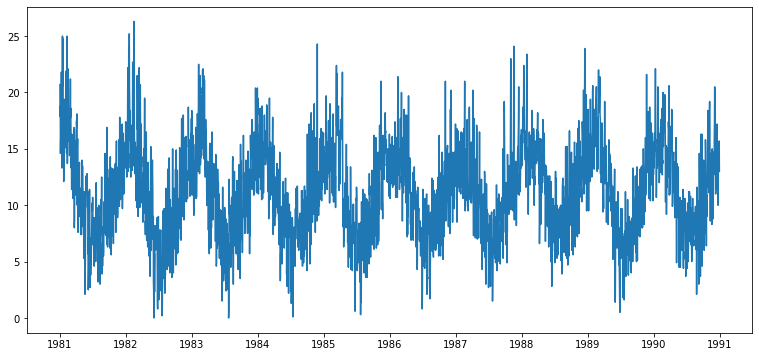

In [7]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)

시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해보자.

아래는 __일정 시간 내 구간 통계치(Rolling Statistics)__를 시각화해 보는 함수이다.

현재 타임스텝 부터 window에 주어진 타임스텝 이전 사이

- 구간의 평균(rolling mean, 이동평균)
- 표준편차(rolling std, 이동표준편차)

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

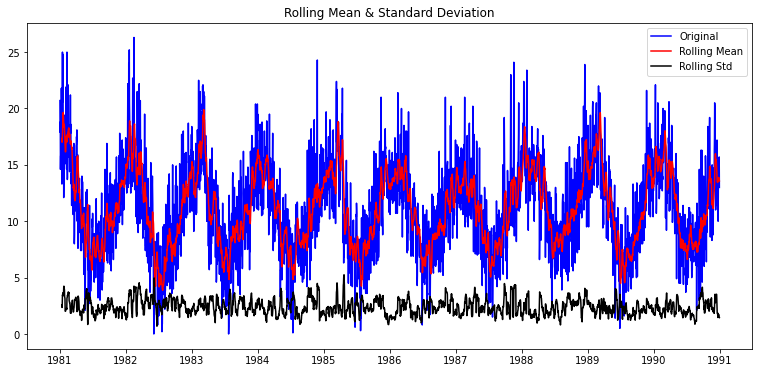

In [9]:
plot_rolling_statistics(ts1, window=12)

시각화한 결과만 놓고 보면 이 시계열 데이터가 안정적이라고 말할수도 있겠지만, 명확하게 단정지으려면 좀 더 통계적인 접근이 필요할 것이다.

## 다른 데이터와 비교
 월별 항공 승객 수(천명 단위)의 시계열 데이터인 `International airlane passengers` 데이터와 비교해보자.

In [10]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

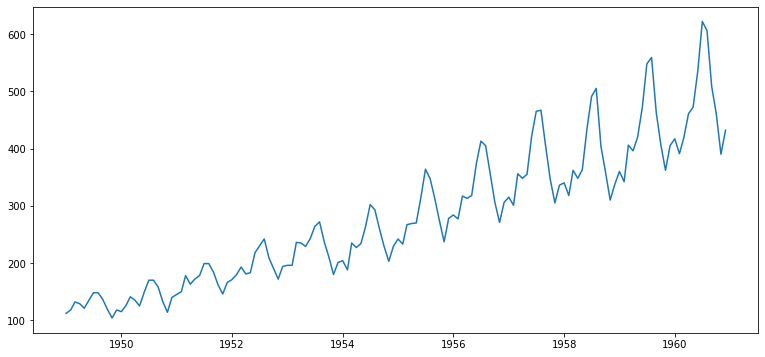

In [11]:
ts2 = df['Passengers']
plt.plot(ts2)

직관적으로 봐도 온도변화 데이터셋과는 다른 패턴이 보인다. 시간의 추이에 따라 시계열의 평균과 분산이 지속적으로 커지는 패턴을 보인다. 

rolling statistics를 추가해서 시각화해보자.

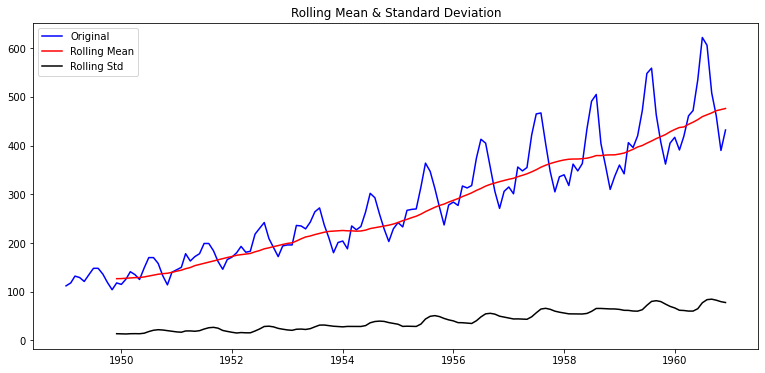

In [12]:
plot_rolling_statistics(ts2, window=12)

이렇게 시간의 추이에 따라 평균과 분산이 증가하는 패턴을 보인다면 이 시계열 데이터는 적어도 안정적이진 않다고 정성적인 결론을 내려볼 수 있다.  

이후 스텝에서 이러한 불안정적(Non-Stationary) 시계열 데이터에 대한 시계열 분석 기법을 다루어보자.

----
## Stationary 여부를 체크하는 통계적 방법

 시계열 데이터의 안정성(stationary)을 테스트할때 __Augmented Dickey-Fuller Test(ADF Test)__ 라는 통계적 방법을 사용한다.
 
 이 테스트의 대략적인 과정은 아래와 같다.
- 주어진 시계열 데이터가 __안정적이지 않다라는 귀무가설(Null Hypothesis)__를 세운 후,
- 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
- 이 시계열 데이터가 __안정적이다라는 대립가설(Alternative Hypothesis)을 채택__한다는 내용

In [13]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

이전 스텝에서 정성적으로 분석해 보았던 두 시계열(Time Series)에 대한 Augmented Dickey-Fuller Test를 수행해보자.

In [15]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


ts1(Daily Minimum Temperatures in Melbourne)시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 0에 가깝게 나타났다.   

따라서 이 __귀무가설은 기각__되고, 이 시계열은 __안정적 시계열이라는 대립가설이 채택__된다.

In [16]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


ts2(International airline passengers) 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 1에 가깝게 나타났다.  

p-value가 1에 가깝다는 것이 이 귀무가설(주어진 시계열 데이터가 안정적이지 않다.) 이 옳다는 직접적인 증거는 아니다.  

하지만 이 __귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없다.__

----
## Stationary 하게 만들기

이전 스텝에서도 언급했듯, 안정적이지 않은 시계열을 분석하려면 이것을 안정적인 시계열로 바꾸어 내야 힌다. 그 방법에는 크게 두 가지가 있다.

- 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 __기존의 시계열 데이터를 가공/변형__하는 시도
- __시계열 분해(Time series decomposition) 기법__을 적용

### 1. 보다 Stationary 한 시계열로 가공

#### 1-1. 로그함수 변환
가장 먼저 고려해 볼 수 있는 것은 시간 추이에 따라 분산이 점점 커지고 있다는 점이다. 시계열이 이런 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 된다.

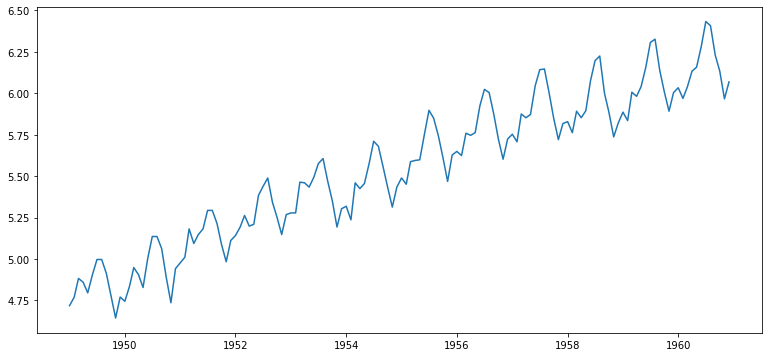

In [17]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [18]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value가 0.42로 무려 절반 이상 줄어들었다. 정성적으로도 시간 추이에 따른 분산이 일정해진 것을 확인할 수 있다.  

하지만 문제점은 여전히 시간 추이에 따라 평균이 계속 증가한다는 점이다.

#### 1-2. Moving average 제거 - 추세(Trend) 상쇄하기

시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 힌다.  이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 `ts_log` 에서 빼주면 된다.

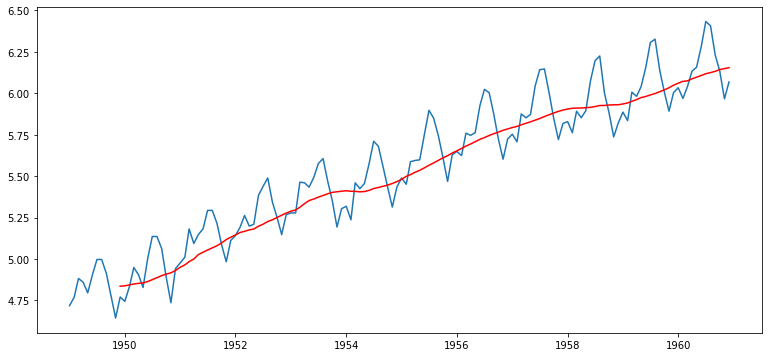

In [19]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [20]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다.  

이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거한다.

In [21]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

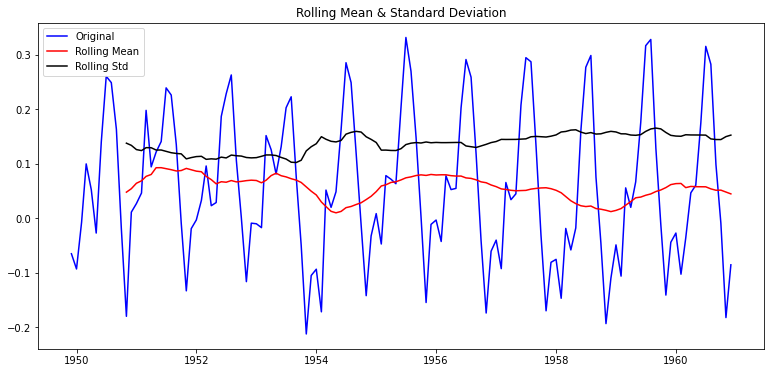

In [22]:
plot_rolling_statistics(ts_log_moving_avg)

In [23]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


드디어 p-value가 0.02 수준이 되었다. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있 다.

 여기서 moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다.

#### 1-3. 차분(Differencing) - 계절성(Seasonality) 상쇄

Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소이다. 이것은 Moving Average 제거로는 상쇄되지 않는 효과이다.  

이런 계절적, 주기적 패턴을 __계절성(Seasonality)__ 이라고 한다.

이런 패턴을 상쇄하기 위해 효과적인 방법에는 __차분(Differencing)__이 있다.  
시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법이다. 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 된다.

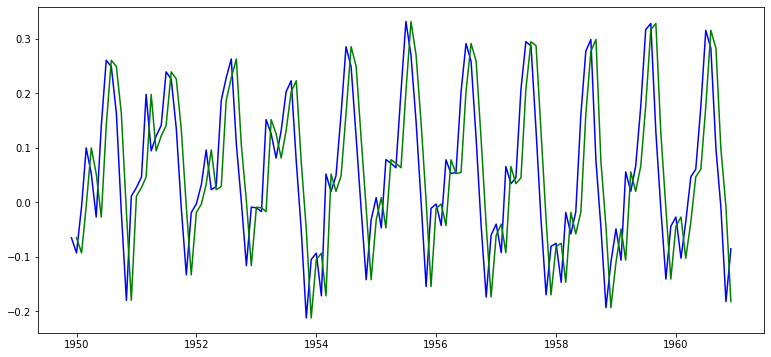

In [24]:
# 시프트한 시계열과 원본 시계열에 대한 그래프
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

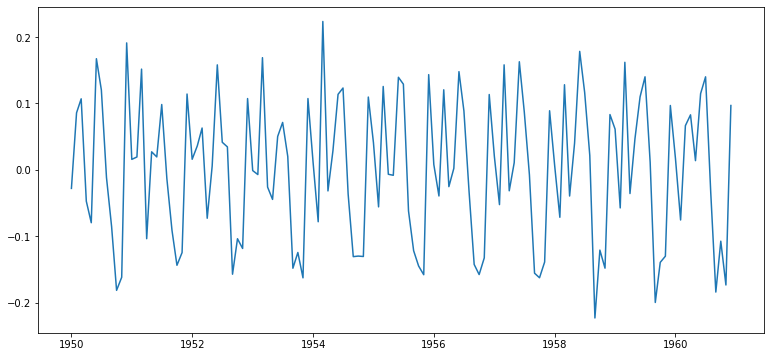

In [25]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악해보자.

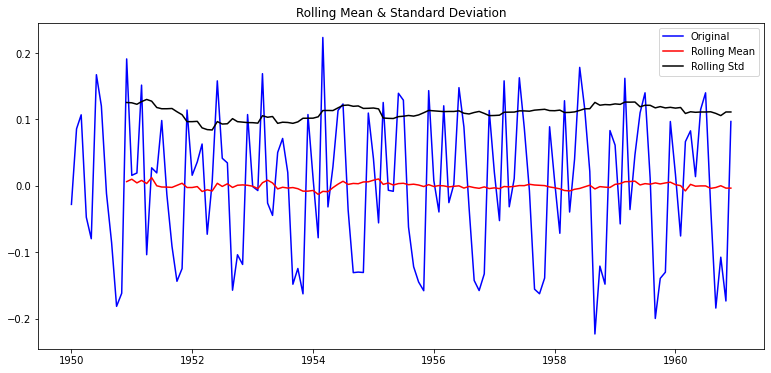

In [26]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [27]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, p-value가 약 0.022 에서 0.0019로 1/10 정도로 줄었음을 확인 할 수 있다.

### 2. 시계열 분해 (Time series decomposition)

`statsmodels` 라이브러리 안에는 `seasonal_decompose` 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있다.  
이 기능을 활용하면 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 된다.


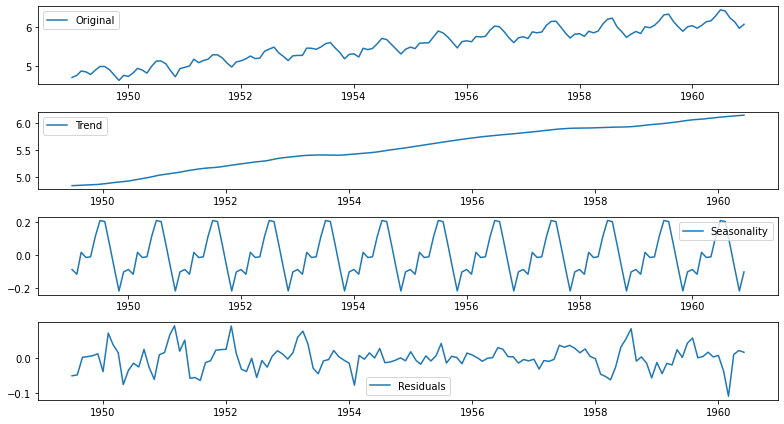

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

`Original` 시계열에서 `Trend`와 `Seasonality`를 제거하고 난 나머지를 `Residual`이라고 한다. 뒤집어서 말하면 `Trend+Seasonality+Residual=Original` 이 성립한다는 뜻이다. 이러한 `Decomposing`은 시계열 데이터를 이해하는 중요한 관점을 제시한다.

`Residual` 에 대해 안정성 여부를 따져보자.

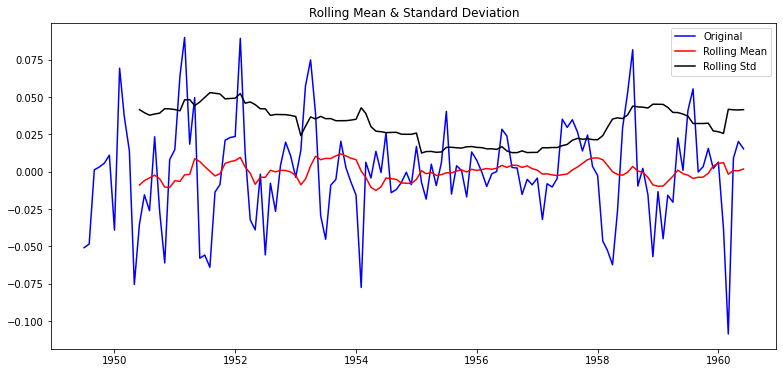

In [29]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [30]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

-----
-----
# ARIMA 모델

## ARIMA 모델의 모수 p, q, d

ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야한다.  

ARIMA의 모수는 아래의 3가지가 있습니다

- `p` : 자기회귀 모형(AR)의 시차
- `q` : 이동평균 모형(MA)의 시차
- `d` : 차분누적(I) 횟수

이들 중 `p` 와 `q `는 일반적으로 `p + q < 2`, `p * q = 0 `인 값을 사용하는데, 이는 `p` 나 `q` 중 하나는 0이라는 뜻이다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문이다.  


#### ACF와 PACF 플로팅

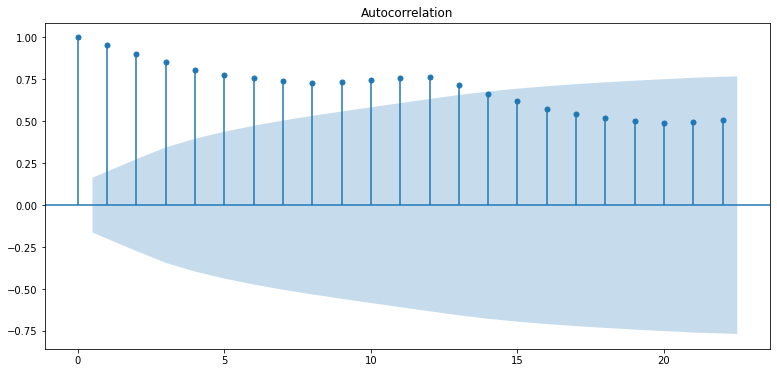

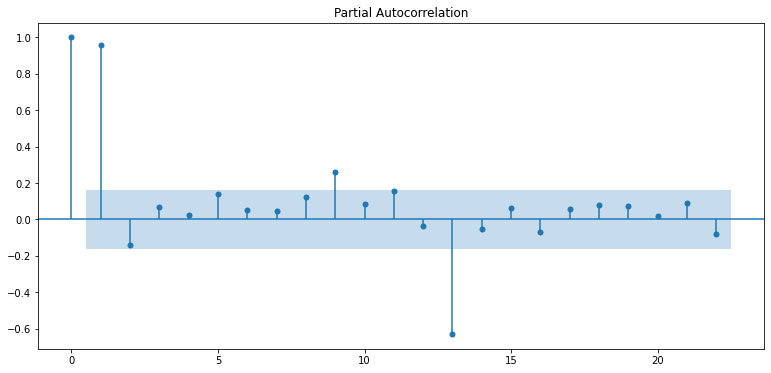

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


__ACF를 통해 MA 모델의 시차 q__를 결정하고, __PACF를 통해 AR 모델의 시차 p__를 결정할 수 있다.


||$AR(p)$|$MA(q)$|
|:----:|:----:|:----:|
|ACF|점차적으로 감소|시차 $q$ 이후에 0|
|PACF|시차 $p$ 이후에 0|점차적으로 감소|





- 이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합
  - p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문. 
  - PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻
  
- ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다. 
- q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠다.

`d` 를 구하기 위해서는 좀 다른 접근이 필요하다. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해보자.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


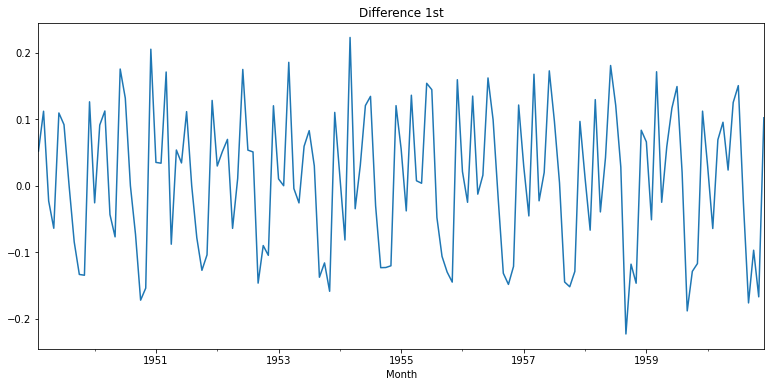

In [32]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


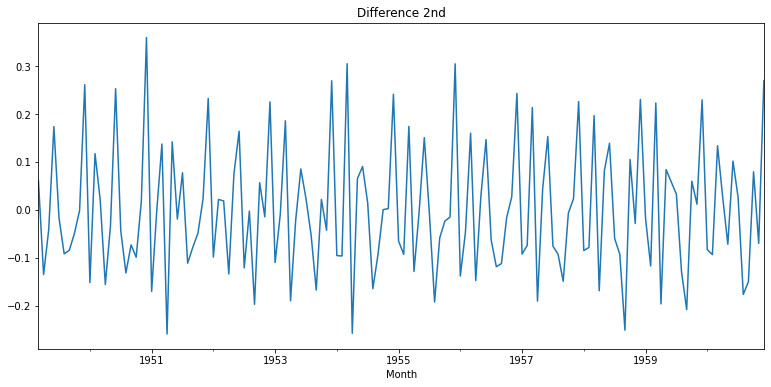

In [33]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

이번 경우에는 1차 차분을 구했을 때 약간 애매한 수준의 안정화 상태를 보였다.  

2차 차분을 구했을 때는 확실히 안정화 상태였지만 이번 경우에는 d=1로 먼저 시도해 볼 수 있을 것 같다.

## 학습 데이터 분리

학습 데이터와 테스트 데이터를 분리해 봅시다. 분리 비율은 학습과 테스트에 9:1로 하겠다. 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당할 것이다.

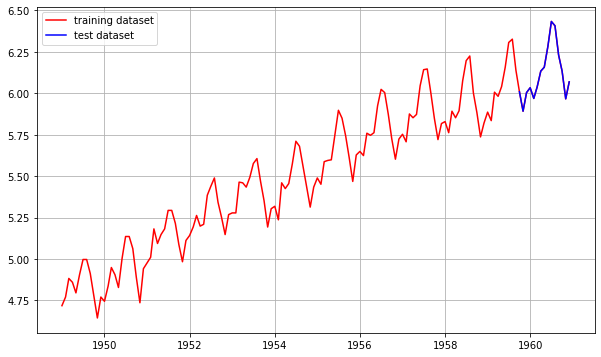

In [34]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [35]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


## ARIMA 모델 훈련과 추론

앞에서 우리는 p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 사용하기로 하였다. ARIMA 모델을 훈련하는 것은 아래와 같이 진행한다.

In [36]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 108.023
Method:                       css-mle   S.D. of innovations              0.104
Date:                Tue, 07 Sep 2021   AIC                           -210.046
Time:                        03:22:54   BIC                           -201.490
Sample:                    02-01-1949   HQIC                          -206.570
                         - 09-01-1959                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0108      0.011      0.972      0.331      -0.011       0.033
ar.L1.D.Passengers     0.1754      0.088      1.994      0.046       0.003       0.348
                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


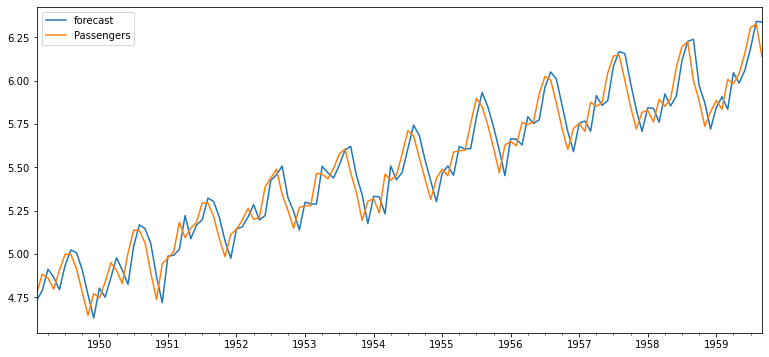

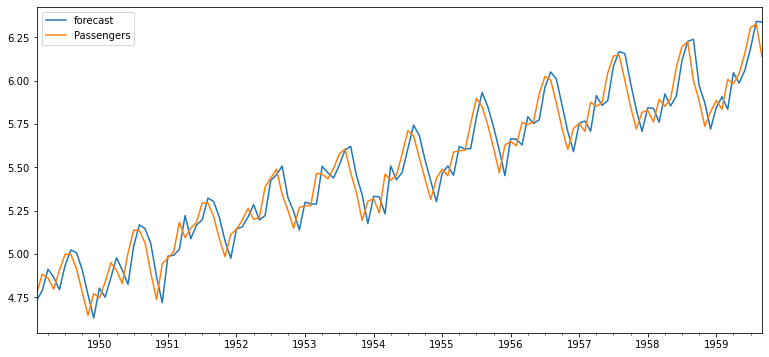

In [37]:
# ARIMA 모델 훈련 결과를 시각적으로 확인
fitted_m.plot_predict()

`forecast()` 메소드를 이용해 테스트 데이터 구간의 데이터를 예측한다.

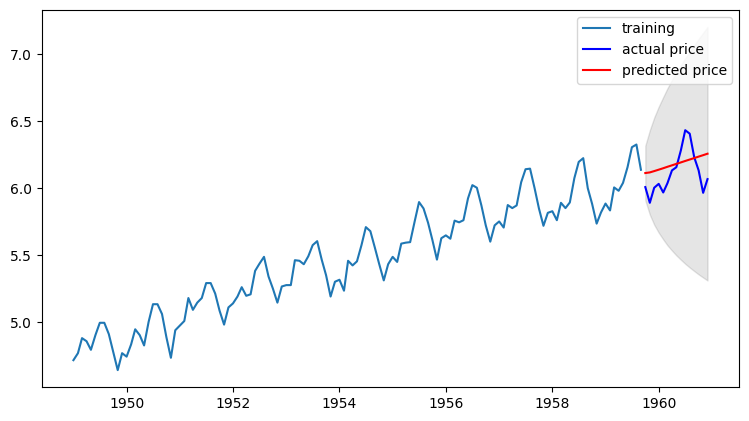

In [38]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다.  
`np.exp()` 를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산한다.

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5409.54978246723
MAE:  63.13692082580771
RMSE:  73.54964162025013
MAPE: 14.08%


최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 14% 정도의 오차율을 보인다.  

더 적당한 모수를 찾을 수 있다면 개선의 여지가 있다.  

q=8을 줄 경우 MAPE가 10% 정도로 내려간다.  
q=12를 쓸 수 있다면 더욱 좋을 거라는 예상이 되지만 이번 경우에는 데이터셋이 너무 작아 쓸 수 없었다.